In [2]:
# Importing libraries

import pandas as pd
import numpy as np

from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

import gensim
from gensim.models import Word2Vec

import warnings
warnings.filterwarnings('ignore')

### Data preparation

In [4]:
# Load the dataset from CSV
data = pd.read_csv('Unbalanced_data.csv')
data.head()

,description,label
0,A 23-year-old white female presents with compl...,Allergy / Immunology
1,"Acute allergic reaction, etiology uncertain, h...",Allergy / Immunology
2,Mother states he has been wheezing and coughing.,Allergy / Immunology
3,Patient having severe sinusitis about two to t...,Allergy / Immunology
4,Functional endoscopic sinus surgery with left ...,Allergy / Immunology


In [5]:
data.isna().sum()

description    6
label          0
dtype: int64

In [6]:
data.label.unique().shape

(40,)

In [7]:
data = data.dropna()
data.isna().sum()

description    0
label          0
dtype: int64

In [8]:
def get_sentence_word_count(text_list):
    sent_count = 0
    word_count = 0
    vocab = {}
    for text in text_list:
        sentences=sent_tokenize(str(text).lower())
        sent_count = sent_count + len(sentences)
        for sentence in sentences:
            words=word_tokenize(sentence)
            for word in words:
                if(word in vocab.keys()):
                    vocab[word] = vocab[word] +1
                else:
                    vocab[word] =1 
    word_count = len(vocab.keys())
    return sent_count,word_count

In [9]:
sent_count,word_count= get_sentence_word_count(data['description'].tolist())
print("Number of sentences in transcriptions column: "+ str(sent_count))
print("Number of unique words in transcriptions column: "+str(word_count))



data_categories  = data.groupby(data['label'])
i = 1
print('===========Original Categories =======================')
for catName,dataCategory in data_categories:
    print('Cat:'+str(i)+' '+catName + ' : '+ str(len(dataCategory)) )
    i = i+1
print('==================================')

Number of sentences in transcriptions column: 8630
Number of unique words in transcriptions column: 5997
===========Original Categories =======================
Cat:1 Allergy / Immunology : 8
Cat:2 Autopsy : 8
Cat:3 Bariatrics : 18
Cat:4 Cardiovascular / Pulmonary : 372
Cat:5 Chiropractic : 14
Cat:6 Consult - History and Phy. : 513
Cat:7 Cosmetic / Plastic Surgery : 27
Cat:8 Dentistry : 27
Cat:9 Dermatology : 30
Cat:10 Diets and Nutritions : 10
Cat:11 Discharge Summary : 108
Cat:12 ENT - Otolaryngology : 99
Cat:13 Emergency Room Reports : 75
Cat:14 Endocrinology : 19
Cat:15 Gastroenterology : 229
Cat:16 General Medicine : 259
Cat:17 Hematology - Oncology : 90
Cat:18 Hospice - Palliative Care : 6
Cat:19 IME-QME-Work Comp etc. : 16
Cat:20 Lab Medicine - Pathology : 8
Cat:21 Letters : 24
Cat:22 Nephrology : 81
Cat:23 Neurology : 222
Cat:24 Neurosurgery : 94
Cat:25 Obstetrics / Gynecology : 160
Cat:26 Office Notes : 53
Cat:27 Ophthalmology : 83
Cat:28 Orthopedic : 359
Cat:29 Pain Management

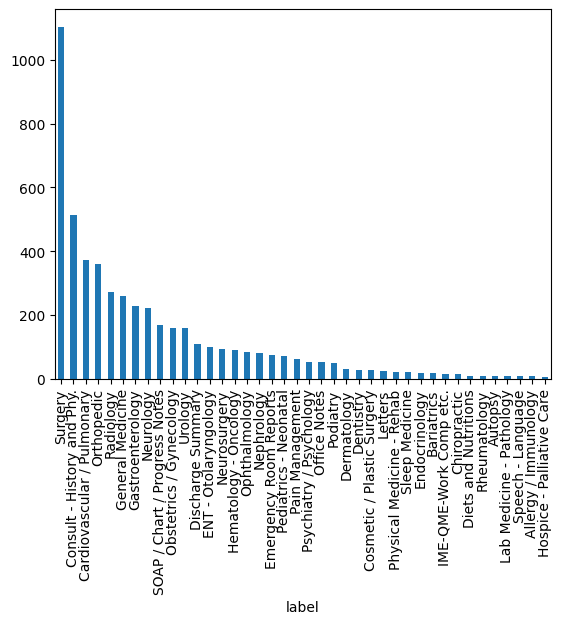

In [10]:
data.label.value_counts().plot.bar()
plt.show()

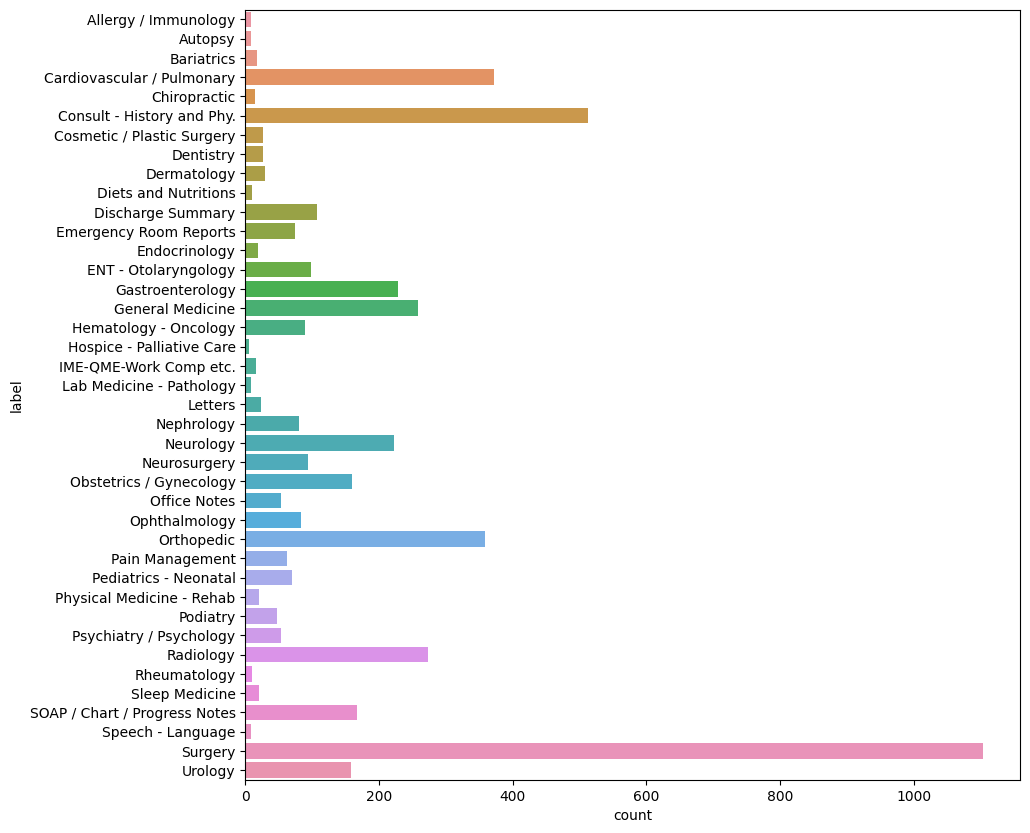

In [11]:
plt.figure(figsize=(10,10))
sns.countplot(y='label', data = data)
plt.show()

In [12]:
# Encode the labels
label_encoder = LabelEncoder()
data['label_encoded'] = label_encoder.fit_transform(data['label'])
num_classes = len(label_encoder.classes_)

In [13]:
data.head()

,description,label,label_encoded
0,A 23-year-old white female presents with compl...,Allergy / Immunology,0
1,"Acute allergic reaction, etiology uncertain, h...",Allergy / Immunology,0
2,Mother states he has been wheezing and coughing.,Allergy / Immunology,0
3,Patient having severe sinusitis about two to t...,Allergy / Immunology,0
4,Functional endoscopic sinus surgery with left ...,Allergy / Immunology,0


In [14]:
data.label_encoded.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 11, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 36, 35, 37, 38, 39])

In [15]:
# Split the dataset into training and testing sets
train_data = data.sample(frac=0.8, random_state=42)
test_data = data.drop(train_data.index)

### Using Randomforest classifier and XGboost classifier

In [16]:
max_features = 5000

vectorizer = TfidfVectorizer(max_features=max_features)
train_features = vectorizer.fit_transform(train_data['description'])
train_labels = train_data['label_encoded']

test_features = vectorizer.transform(test_data['description'])
test_labels = test_data['label_encoded']

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(train_features, train_labels)
rf_predictions = rf_model.predict(test_features)

# XGBoost Classifier
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(train_features, train_labels)
xgb_predictions = xgb_model.predict(test_features)

# Evaluate the models
rf_accuracy = accuracy_score(test_labels, rf_predictions)
rf_precision = precision_score(test_labels, rf_predictions, average='macro')
rf_recall = recall_score(test_labels, rf_predictions, average='macro')
rf_f1 = f1_score(test_labels, rf_predictions, average='macro')

xgb_accuracy = accuracy_score(test_labels, xgb_predictions)
xgb_precision = precision_score(test_labels, xgb_predictions, average='macro')
xgb_recall = recall_score(test_labels, xgb_predictions, average='macro')
xgb_f1 = f1_score(test_labels, xgb_predictions, average='macro')

# Compare the performances
print("Random Forest Classifier Performance:")
print(f"Accuracy: {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-score: {rf_f1:.4f}")
print("-----------------------------------")
print("XGBoost Classifier Performance:")
print(f"Accuracy: {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall: {xgb_recall:.4f}")
print(f"F1-score: {xgb_f1:.4f}")

Random Forest Classifier Performance:
Accuracy: 0.0709
Precision: 0.0598
Recall: 0.0504
F1-score: 0.0527
-----------------------------------
XGBoost Classifier Performance:
Accuracy: 0.0839
Precision: 0.0814
Recall: 0.0777
F1-score: 0.0788


### Using Naive Bayes and SVM classifiers on the N-gram model features

In [17]:
ngram_range = (1, 2)  # Set the N-gram range

vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
train_features = vectorizer.fit_transform(train_data['description'])
train_labels = train_data['label_encoded']

test_features = vectorizer.transform(test_data['description'])
test_labels = test_data['label_encoded']

# Train the N-gram model with SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(train_features, train_labels)
svm_predictions = svm_model.predict(test_features)

# Evaluate the N-gram model
svm_accuracy = accuracy_score(test_labels, svm_predictions)
svm_precision = precision_score(test_labels, svm_predictions, average='macro')
svm_recall = recall_score(test_labels, svm_predictions, average='macro')
svm_f1 = f1_score(test_labels, svm_predictions, average='macro')

# Train the Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(train_features, train_labels)
nb_predictions = nb_model.predict(test_features)

# Evaluate the models
nb_accuracy = accuracy_score(test_labels, nb_predictions)
nb_precision = precision_score(test_labels, nb_predictions, average='macro')
nb_recall = recall_score(test_labels, nb_predictions, average='macro')
nb_f1 = f1_score(test_labels, nb_predictions, average='macro')

# Compare the performances
print("Naive Bayes Classifier Performance:")
print(f"Accuracy: {nb_accuracy:.4f}")
print(f"Precision: {nb_precision:.4f}")
print(f"Recall: {nb_recall:.4f}")
print(f"F1-score: {nb_f1:.4f}")
print("-----------------------------------")

print("SVM Model Performance:")
print(f"Accuracy: {svm_accuracy:.4f}")
print(f"Precision: {svm_precision:.4f}")
print(f"Recall: {svm_recall:.4f}")
print(f"F1-score: {svm_f1:.4f}")

Naive Bayes Classifier Performance:
Accuracy: 0.2927
Precision: 0.0476
Recall: 0.0550
F1-score: 0.0406
-----------------------------------
SVM Model Performance:
Accuracy: 0.1768
Precision: 0.0697
Recall: 0.0595
F1-score: 0.0603


### Using Word2Vec instead of TfidfVectorizer for SVM and Naive Bayes models

In [19]:
# Sample text corpus (replace this with your own text data)
corpus = train_data['description'].tolist() + test_data['description'].tolist()

# Train the Word2Vec model
tokenized_corpus = [sentence.lower().split() for sentence in corpus]
word2vec_model = Word2Vec(tokenized_corpus, vector_size=100, window=5, min_count=1, workers=4)

# Function to calculate document embeddings
def get_doc_embedding(doc_tokens):
    # Initialize an empty array to store word vectors
    doc_vector = np.zeros(word2vec_model.vector_size)

    # Count the number of words in the document
    word_count = 0

    # Iterate over each word in the document and add its word vector to the document vector
    for word in doc_tokens:
        if word in word2vec_model.wv:
            doc_vector += word2vec_model.wv[word]
            word_count += 1

    # Divide the document vector by the number of words to get the average
    if word_count > 0:
        doc_vector /= word_count

    return doc_vector

# Get document embeddings for all sentences in the train_data
train_features = np.array([get_doc_embedding(doc_tokens) for doc_tokens in tokenized_corpus[:len(train_data)]])

# Get document embeddings for all sentences in the test_data
test_features = np.array([get_doc_embedding(doc_tokens) for doc_tokens in tokenized_corpus[len(train_data):]])

# Convert train_labels and test_labels to numpy arrays
train_labels = train_data['label_encoded'].values
test_labels = test_data['label_encoded'].values

# Convert the Word2Vec embeddings to text data for Gaussian Naive Bayes
train_text_data = [' '.join(map(str, doc)) for doc in train_features]
test_text_data = [' '.join(map(str, doc)) for doc in test_features]

# Vectorize the text data using TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
train_features_tfidf = vectorizer.fit_transform(train_text_data)
test_features_tfidf = vectorizer.transform(test_text_data)

# Train the SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(train_features, train_labels)
svm_predictions = svm_model.predict(test_features)

# Evaluate the SVM model
svm_accuracy = accuracy_score(test_labels, svm_predictions)
svm_precision = precision_score(test_labels, svm_predictions, average='macro')
svm_recall = recall_score(test_labels, svm_predictions, average='macro')
svm_f1 = f1_score(test_labels, svm_predictions, average='macro')

# Train the Naive Bayes classifier
nb_model = GaussianNB()
nb_model.fit(train_features_tfidf.toarray(), train_labels)
nb_predictions = nb_model.predict(test_features_tfidf.toarray())

# Evaluate the Naive Bayes classifier
nb_accuracy = accuracy_score(test_labels, nb_predictions)
nb_precision = precision_score(test_labels, nb_predictions, average='macro')
nb_recall = recall_score(test_labels, nb_predictions, average='macro')
nb_f1 = f1_score(test_labels, nb_predictions, average='macro')

# Compare the performances
print("Naive Bayes Classifier Performance:")
print(f"Accuracy: {nb_accuracy:.4f}")
print(f"Precision: {nb_precision:.4f}")
print(f"Recall: {nb_recall:.4f}")
print(f"F1-score: {nb_f1:.4f}")
print("-----------------------------------")

print("SVM Model Performance:")
print(f"Accuracy: {svm_accuracy:.4f}")
print(f"Precision: {svm_precision:.4f}")
print(f"Recall: {svm_recall:.4f}")
print(f"F1-score: {svm_f1:.4f}")

Naive Bayes Classifier Performance:
Accuracy: 0.0070
Precision: 0.0251
Recall: 0.0276
F1-score: 0.0049
-----------------------------------
SVM Model Performance:
Accuracy: 0.2567
Precision: 0.0238
Recall: 0.0405
F1-score: 0.0239
